# Télécharger et charger le jeu de données

In [1]:
import os
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Telecharger le jeu de donnees a partir de Kaggle
adsSales = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "thorgodofthunder/tvradionewspaperadvertising/versions/1",
    "Advertising.csv",
)

# Jeu de données utilisé en exemple: https://www.kaggle.com/datasets/thorgodofthunder/tvradionewspaperadvertising
# Propriétaire: Thor God of Thunder (Kaggle)

# Explorer la structure du jeu de données

In [2]:
adsSales.head() # 5 premieres entrées
adsSales.info() # Type de chaque attribut (exple: catégorie, numérique)
adsSales.describe() # Statistiques des attributs de type numérique

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Radio'}>],
       [<Axes: title={'center': 'Newspaper'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

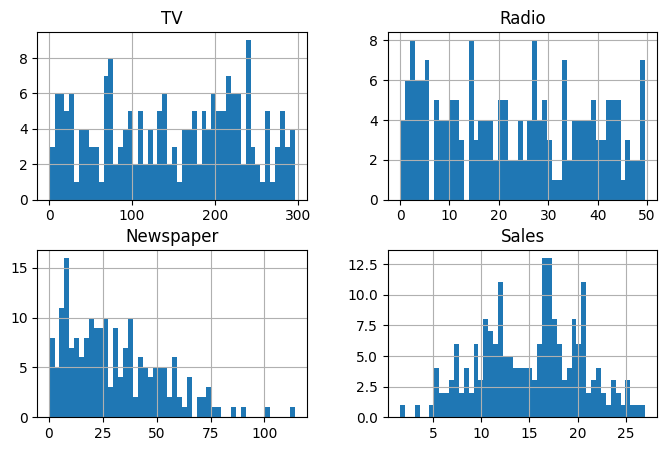

In [3]:
# Compter les niveaux pour les attributs catégoriels (le cas échéant)
# Histogramme des attributs numériques
%matplotlib inline
import matplotlib.pyplot as plt
adsSales.hist(bins=50, figsize=(8,5))

# Créer le jeu de données de test

<Axes: >

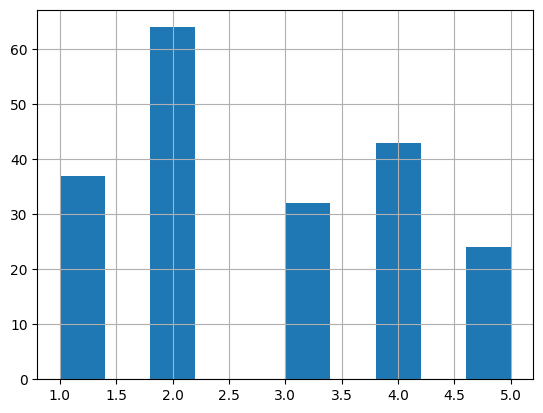

In [4]:
# Supposes des groupes sous-jacentes pour l'attribut TV
import numpy as np

# Création de catégories pour l'attribut TV
adsSales["TV_cat"] = pd.cut(adsSales["TV"],
                                   bins=[0., 50., 150., 200., 250., np.inf],
                                   labels=[1, 2, 3, 4, 5])
adsSales["TV_cat"].hist()


In [5]:
# Division du jeu de donnés en données d'apprentissage et de test, avec groupage par l'attribut TV
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(adsSales, adsSales["TV_cat"]):
    strat_train_set = adsSales.loc[train_index]
    strat_test_set = adsSales.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("TV_cat", axis=1, inplace=True)

# Découverte et visualisation des données

In [6]:
# Copie des données pour l'apprentissage
adsSales = strat_train_set.copy()

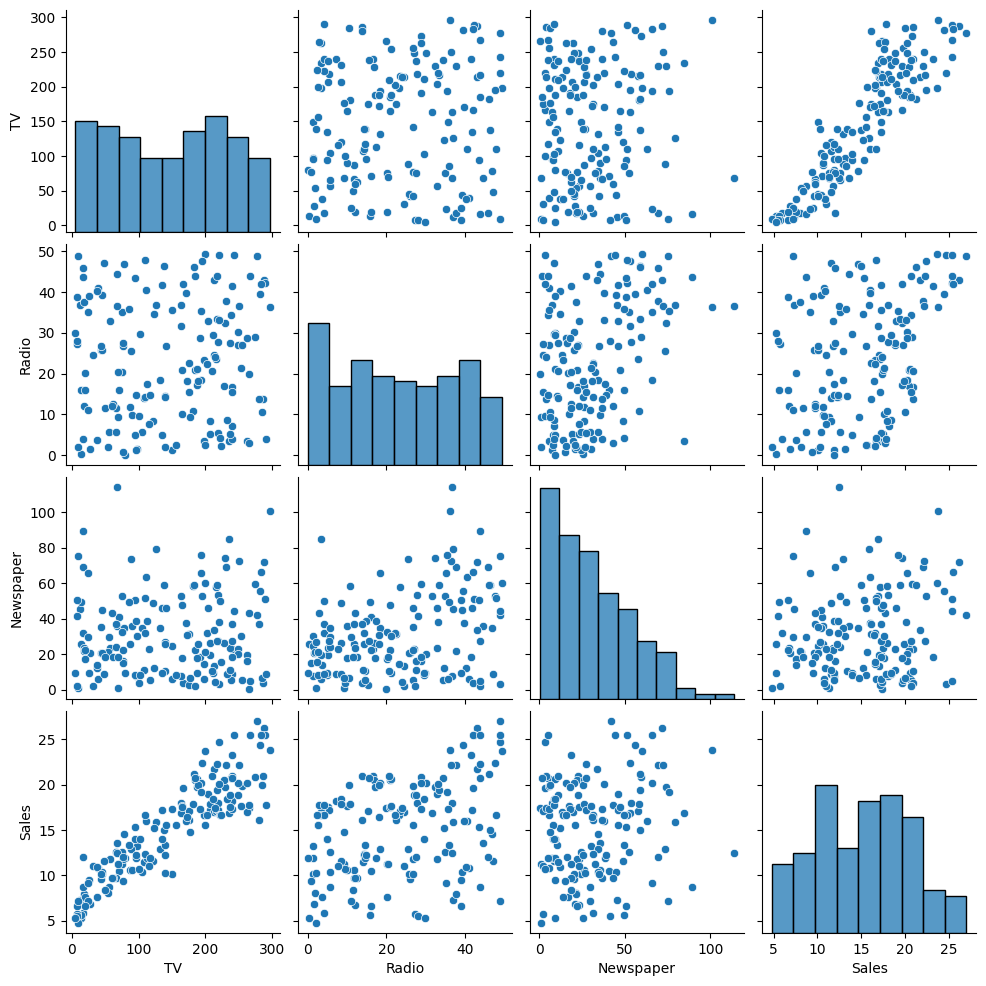

In [7]:
# Visualization de la linearite entre attributs
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("colorblind")

sns.pairplot(adsSales)
plt.savefig("multicol.pdf", format="pdf", bbox_inches="tight", dpi=300) # Sauvegarde du graphique en .pdf
plt.show()

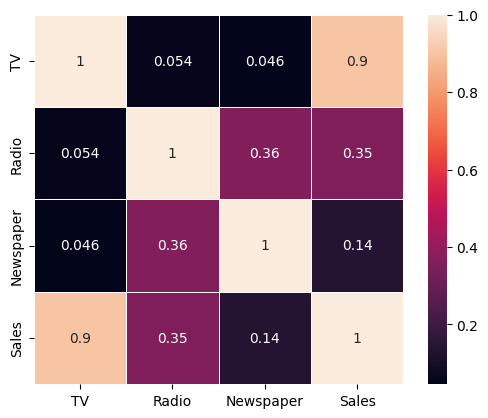

In [8]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation de la correlation entre attributs
corr_matrix = adsSales.corr()

# Visualization de la correlation 
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, square=True)
plt.savefig("eda.pdf", format="pdf", bbox_inches="tight", dpi=300) # Sauvegarde du graphique en fichier .pdf
plt.show()

# Remarque : on pourrait décider de se concentrer uniquement sur les attributs prometteurs (TV, Radio)
#            pour l'instant, nous conservons les trois, car ils ne sont pas si nombreux

In [9]:
# Transformation des attributs faiblements correlés avec l'attribut "Sales"
adsSales["logRadio"] = np.log(adsSales["Radio"])
adsSales["logNewspaper"] = np.log(adsSales["Newspaper"])

# Matrice de correlation
corr_matrix = adsSales.corr()
corr_matrix["Sales"].sort_values(ascending=False)

## Note: La transformation Logarithmique n'améliore pas la correlation

/media/christian/22F4BCAE291A75E1/Learning/MLenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Sales           1.000000
TV              0.903030
Radio           0.354472
logRadio        0.339342
Newspaper       0.136760
logNewspaper    0.069753
Name: Sales, dtype: float64

# Préparation des donées pour les models de ML

In [10]:
## Remarques : 
##       1.- ces données sont propres et ne comportent aucune donnée manquante, il n'est donc pas nécessaire de procéder à une imputation.
##       2.- D'autres transformations que la transformation logarithmique pourraient être testées, mais nous préférons rester simples.
##       3.- Comme il n'y a pas d'attributs catégoriels, il n'est pas nécessaire de recourir au codage OneHotEncoding.

# Récupération des données d'entraînement
adsSales = strat_train_set.drop("Sales", axis=1)
adsSales_labels = strat_train_set["Sales"].copy()

# Standardization des attributs numériques
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline pour les attributs numériques (à titre d'exemple, puisqu'il n'y a qu'un seul transformateur)
num_pipeline = Pipeline([
    ('attribs_scaler', StandardScaler()),
])

## Pipeline complet
num_attribs = list(adsSales)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
])

adsSales_prepared = full_pipeline.fit_transform(adsSales)

# Sélection et entraînement de modèles

In [11]:
# Evaluation sur les donnees d'entrainement : régression linéaire

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(adsSales_prepared, adsSales_labels)

adsSales_predictions = lin_reg.predict(adsSales_prepared)
lin_mse = mean_squared_error(adsSales_labels, adsSales_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(1.5763961155539867)

In [12]:
# Evaluation sur les donnees d'entrainement : arbre de décision

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(adsSales_prepared, adsSales_labels)

adsSales_predictions = tree_reg.predict(adsSales_prepared)
tree_mse = mean_squared_error(adsSales_labels, adsSales_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

## Note: l'arbre de décision overfit le jeu de données

np.float64(0.0)

/tmp/ipykernel_66500/2141194101.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='RMSE', data=df, palette='colorblind', width=0.5)


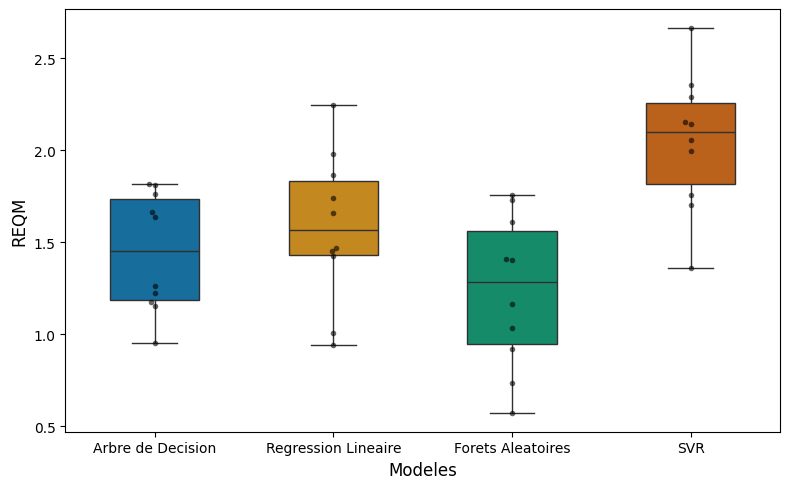

In [ ]:
# Evaluation sur les donnees d'entrainement : validation croisée K-fold

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

def boxplot_scores(scores_dict):
    """
        Visualizer les grapgiques "boxplots" pour le RMSE de plusieurs modèles à partir des scores de validation croisée.

        Paramètres
        ----------
        scores_dict : dict
            Dictionnaire dans lequel les clés sont les noms des modèles (str) et les valeurs sont des listes de scores RMSE.
            Exemple :
                {
                    "Random Forest" : [0,42, 0,39, 0,41, ...],
                    "XGBoost" : [0,36, 0,35, 0,37, ...],
                    "Linear Regression" : [0,50, 0,48, 0,51, ...]
                }
    """

    # Convertir le dictionnaire en DataFrame au format long
    df = pd.DataFrame({
        "Model": [model for model, scores in scores_dict.items() for _ in scores],
        "RMSE": [score for scores in scores_dict.values() for score in scores]
    })
    
    # Créer le graphique
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Model', y='RMSE', data=df, palette='colorblind', width=0.5)
    sns.swarmplot(x='Model', y='RMSE', data=df, color='black', alpha=0.6, size=4)
    
    # Formatage du graphique
    plt.xlabel('Modeles', fontsize=12)
    plt.ylabel('REQM', fontsize=12)
    plt.tight_layout()
    plt.savefig("scores_FR.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.show()

# Evaluer les performances de certains models
# Arbre de decision
scores = cross_val_score(tree_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# Regression lineaire
scores = cross_val_score(lin_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

# Random forest
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

# Support vector machine
svm_reg = SVR()
scores = cross_val_score(svm_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

boxplot_scores({"Arbre de Decision":tree_rmse_scores, "Regression Lineaire":lin_rmse_scores,
                "Forets Aleatoires":forest_rmse_scores, "SVR":svm_rmse_scores})

# Affiner le meilleur modèle (Random Forest)

In [21]:
# Réglage des hyperparamètres à l'aide d'une recherche par grille

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)

# Modèle évalué pour toutes les combinaisons de paramètres
grid_search.fit(adsSales_prepared, adsSales_labels)

,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [6, 8, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,10


In [22]:
# Résultat de la recherche par grille

grid_search.best_params_    # Parametres du meilleur model
grid_search.best_estimator_ # Meilleur model
cvres = grid_search.cv_results_

# Evaluation du model sur les donnees de test

In [23]:
# Sélection du meilleur modèle obtenu à partir de la recherche par grille

final_model = grid_search.best_estimator_

In [24]:
# Définition des données de test

X_test = strat_test_set.drop("Sales", axis=1)
y_test = strat_test_set["Sales"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [25]:
# Évaluation du modèle sur les données de test

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(1.2357052642114945)

In [26]:
# Erreurs de généralisation avec un intervalle de confiance de 95%

from scipy import stats

confidence = 0.95
squarred_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squarred_errors)-1,
                        loc=squarred_errors.mean(),
                        scale=stats.sem(squarred_errors)))

array([0.57177817, 1.6513645 ])

# Sauvegarde du modèle final

In [27]:
# Enregistrer le modèle sous forme de fichier joblib

def save_model(model, name="model", model_path="./"):
    """
    Enregistrer le modèle sous un nom donné à un emplacement spécifique.
    
    Paramètres
    ----------
    model : 
        Le modèle entraîné.
    name :
        Le nom du fichier sous lequel enregistrer le modèle.
    model_path :
        Le chemin d'accès où le modèle est enregistré.
        Exemple :
            "./models/"
            
    """
    os.makedirs(model_path, exist_ok=True)
    model_name = name + ".pkl"
    pkl_path = os.path.join(model_path, model_name)
    joblib.dump(model, pkl_path)

MODEL_PATH = os.path.join("models", "adsSales")
save_model(final_model, name="Random_forest_V1.1", model_path=MODEL_PATH)